## Example of geodesic integration on multiple charts

This example illustrate the use of the function ``solve_across_char`` to integrate a geodesic of the euclidean plane (a straight line) in polar coordinates. 

In pure polar coordinates $(r, \theta)$, artefacts can appear near the origin because of the fast variation of $\theta$, resulting in the direction of the geodesic being different before and after getting close to the origin.

The solution to this problem is to switch to cartesian coordiantes near $(0,0)$ to avoid any singularity.

In [1]:
%display latex

#### Manifold declaration

First let's declare the plane as a 2-dimensional manifold, with two charts $P$ and $C$ (for "Polar" and "Cartesian") and their transition maps.

In [2]:
M = Manifold(2, 'M', structure="Riemannian")

C.<x,y> = M.chart()
P.<r,th> = M.chart()

P_to_C = P.transition_map(C,(r*cos(th), r*sin(th)))
C_to_P = C.transition_map(P,(sqrt(x**2+y**2), atan2(y,x)))

Let's also Add restrictions on those charts, to avoid any singularity. We have to make sure that the charts still intersect. Here the intersection is the donut region $2<r<3$.

In [3]:
P.add_restrictions(r > 2)
C.add_restrictions(x**2+y**2 < 3**2)

We still have to define the metric. This is done in the cartesian frame. The metric in the polar frame is computed automatically.

In [4]:
g = M.metric()

g[C.frame(),0,0]=1
g[C.frame(),1,1]=1

In [5]:
g[P.frame(), : ,P]

[  1   0]
[  0 r^2]

To visualize our manifold, let's declare a mapping between every chart and the cartesian chart, and then plot each chart in term of this mapping:

In [6]:
phi = M.diff_map(M, {(C,C): [x, y], (P,C): [r*cos(th), r*sin(th)]})

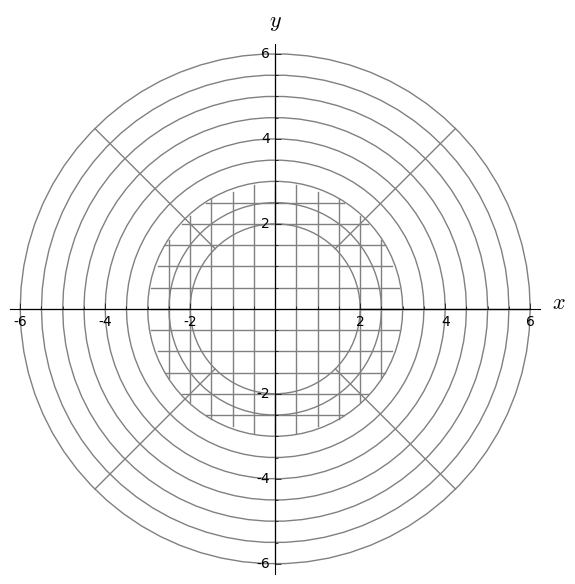

In [7]:
fig = P.plot(number_values=9, chart=C, mapping=phi, color='grey', ranges= {r:(2, 6), th:(0,2*pi)})
fig += C.plot(number_values=13, chart=C, mapping=phi, color='grey', ranges= {x:(-3, 3), y:(-3, 3)})
fig.show(aspect_ratio=1)

We can see that there is a clear non-empty intersection between the two charts. This is the key point to successfully switch chart during the integration. Indeed, at least 2 points must fall in the intersection.

#### Geodesic integration

Let's define the time as $t$, the initial point as $p$, and the initial velocity vector as $v$ (define as a member of the tangent space $T_p$). The chosen geodesic should enter the central region from the left and leave it to the right.

In [8]:
t = var('t')

In [9]:
p = M((5,pi+0.3), P)
Tp = M.tangent_space(p)
v = Tp((-1,-0.03), P.frame().at(p))

While creating the integrated geodesic, we need to specify the optional argument ``across_chart=True``, to prepare the compiled version of the changes of charts.

In [10]:
c = M.integrated_geodesic(g, (t, 0, 10), v, across_charts=True)

The integration is done as usual, but using the method ``solve_across_chart`` instead of ``solve``. This forces the use of ``scipy.integrate.ode`` as the solver, because of event handling support.

The argument``verbose=True`` will cause the solver to write a small message each time it is switching chart.

In [11]:
sol = c.solve_across_charts(step=0.1, verbose=True)

Performing numerical integration with method 'ode'.
Integration will take place on the whole manifold domain.
Resulting list of points will be associated with the key 'ode_multichart' by default.
   ...
Exiting chart, trying to switch to another chart.
New chart found. Resuming integration.
   ...
Exiting chart, trying to switch to another chart.
New chart found. Resuming integration.
   ...
Integration successful


As expected, two changes of chart occur.

The returned solution is a list of couple (chart, solution), where each solution is given on a unique chart, and the last point of a solution is the first of the next.

The following code prints the corresponding charts.

In [12]:
for chart, solution in sol:
    print chart

Chart (M, (r, th))
Chart (M, (x, y))
Chart (M, (r, th))


The interpolation is done as usual:

In [13]:
interp = c.interpolate()

To plot the result, you must first be sure that the mapping encompasses all charts, which is the case here (see cell 6).

You must also specify ``across_charts=True`` in order to call ``plot_integrated`` again on each part.

Finally, ``color`` can be a list, which will be cycled through. 

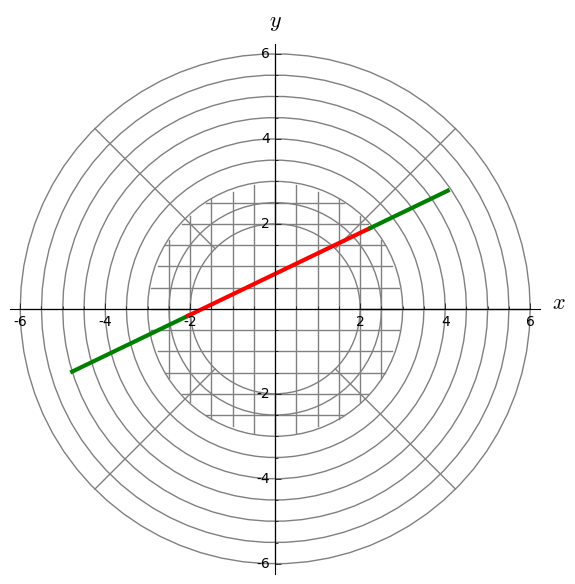

In [14]:
fig += c.plot_integrated(mapping=phi, color=["green","red"], thickness=3, plot_points=100, across_charts=True)
fig.show(aspect_ratio=1)